In [21]:
import menzalib as mz
import numpy as np
import pylab as pl

In [43]:
def theta(x):
    if x>0: return 1
    return 0

def falfat(V,V0,a,b,I0,alfa):
    return a*theta(V0-V)*np.abs(V0-V)**alfa+b*V+I0
falfa=np.vectorize(falfat)

def f2t(V,V0,a,b,I0):
    return a*theta(V0-V)*(V0-V)**2+b*V+I0
f2=np.vectorize(f2t)

20.618898604035206 0.9855456186047458
[ 1.27769356e+00 -1.07606053e-09  1.93195740e-11 -1.86299838e-11
  2.09873033e+00] 
 [4.87274097e-04 9.20402668e-22 2.90654820e-24 5.82825518e-24
 1.54801694e-02]


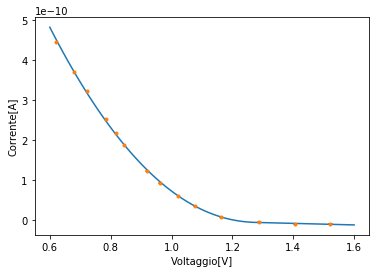

In [94]:
viola=450e-9 
dviola=9.6e-9

#dati ed errori
I450,V450=np.genfromtxt('dati/450nm.txt',unpack='True')
I450=I450*1e-12
V450=V450*1e-3
dV450=mz.dVdig(V450)
dI450=np.empty(len(I450))
for i in range(len(I450)):
    if I450[i]>-200e-12: dI450[i]=np.sqrt((I450[i]*4e-3)**2+(1e-13)**2)
    else: dI450[i]=np.sqrt((I450[i]*4e-3)**2+(1e-12)**2)
        
#fit
popt,pvalue,dpopt,chi,pval=mz.curve_fitdx(falfa,V450,I450,dV450,dI450,p0=[1.213,0,0,0,2],chi2pval=True)
print(chi,pval)
print(popt,'\n',pcov.diagonal())


#plot
x=np.linspace(0.6,1.6,100)
y=falfa(x,*popt)
pl.plot(x,-y)
pl.errorbar(V450,-I450,xerr=dV450,yerr=dI450,fmt='.')
pl.xlabel('Voltaggio[V]')
pl.ylabel('Corrente[A]')
pl.show()

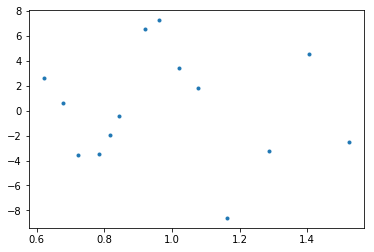

In [77]:
#pl.errorbar(V450,I450-falfa(V450,*popt),xerr=dV450,yerr=dI450,fmt='.')
pl.plot(V450,(I450-falfa(V450,*popt))/dI450,'.')


In [ ]:
verde=577e-9
dverde=10e-9

#dati ed errori
V577,I577=np.genfromtxt('dati/577nm.txt',unpack='True')
I577=I577*1e-12
V577=V577*1e-3
dV577=mz.dVdig(V577)
dI577=np.sqrt((I577*4e-3)**2+(1e-13)**2)
        
    
pl.errorbar(V577,-I577,xerr=dV577,yerr=dI577,fmt='.')
pl.xlabel('Voltaggio[V]')
pl.ylabel('Corrente[A]')
pl.show()